# Preliminary

In [1]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import sys
BASE_PATH = os.path.realpath('..')
DATASETS_DIR = os.path.join(BASE_PATH, 'datasets')
LIB_DIR = os.path.join(BASE_PATH,'lib')
if LIB_DIR not in sys.path:
    sys.path.append(LIB_DIR)

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

from importlib import reload

In [2]:
import fca_interp as fcai

In [3]:
def delete_nocontrib_concepts(fm, conj_form=True, eps=None):
    improv_metric = 'y_pred'
    to_see = range(len(fm._concepts)-1,0,-1)
    for c_id in to_see:
        c = fm.get_concept_by_id(c_id)
        if len(c.get_extent())==0:
            fm.delete_concept(c_id)
            continue

        upns = c._up_neighbs
        if len(upns)>0:
            flg = len(upns)
            for upn_id in upns:
                upn = fm.get_concept_by_id(upn_id)
                upn_val = dict({'y_true':upn._y_true_mean, 'y_pred':upn._y_pred_mean}, **upn._metrics)[improv_metric]
                c_val = dict({'y_true':c._y_true_mean, 'y_pred':c._y_pred_mean}, **c._metrics)[improv_metric]
                if eps is not None:
                    if upn_val is None:
                        continue
                    if abs(c_val-upn_val)<=eps:
                        flg = 0 if conj_form else flg-1
                        if flg == 0:
                            break
                else:
                    if not (c_val==upn_val and c_val in [0,1]):# or abs(c_val-upn_val)<=eps:
                        #flg = False
                        flg = 0 if conj_form else flg-1
                        if flg == 0:
                            break

            if flg==0:
                #print(c_id, upn_id)
                fm.delete_concept(c_id)

In [4]:
def print_contributions(fm):
    asr = []
    itr = 1
    for c in sorted(fm._concepts, key=lambda c: c._idx):
        if c._y_pred_mean is None:
                continue
        for un_idx in c._up_neighbs:
            un = fm.get_concept_by_id(un_idx)
            new_int = [i for i in c._intent if i not in un._intent]
            d = c._y_pred_mean-un._y_pred_mean
            asr.append((new_int, un._intent, d))
            print(f"{itr}) {c._idx}->{un_idx}: c({', '.join(new_int)} | {', '.join(un._intent)}) -> {d:.2f}")
            itr += 1
        #if len(c._extent)>0:
        #    print(f"{c._idx}: {', '.join(c._intent) if len(c._intent)>0 else '()'} => {c._y_pred_mean:.2f}")    
    return asr

In [28]:
def plot_concepts_as_hypotheses(concepts, sort_by_idx=True):
    if type(concepts) not in [list, tuple]:
        concepts = [concepts]
    concepts = [c for c in concepts if c._y_pred_mean is not None]
    if sort_by_idx:
        concepts = sorted(concepts, key=lambda c: c._idx)
    for c in concepts:
        print(f"* {c._idx}: {','.join(c._intent if c._intent is not None else [])} -> {c._y_pred_mean:.2f}")

In [29]:
def plot_base_pos_neg_hypotheses(fm, base_pred=None):
    base_pred = fm.get_concept_by_id(0)._y_pred_mean if base_pred is None else base_pred
    concepts = [c for c in fm._concepts if c._y_pred_mean is not None]
    print('-------------------------')
    print('Base hypothesis')
    print('-------------------------')
    #plot_concepts_as_hypotheses(fm.get_concept_by_id(0))
    print(f'* 0: _ -> {base_pred:.2f}')
    print()
    print('-------------------------')
    print('Positive hypotheses')
    print('-------------------------')
    plot_concepts_as_hypotheses(sorted([c for c in concepts if c._y_pred_mean>base_pred], key=lambda c: c._y_pred_mean))
    print()
    print('-------------------------')
    print('Negative hypotheses')
    print('-------------------------')
    plot_concepts_as_hypotheses(sorted([c for c in concepts if c._y_pred_mean<base_pred], key=lambda c: -c._y_pred_mean))    

In [7]:
def delete_lower_neighbs(fm, c):
    lns = [fm.get_concept_by_id(ln_id) for ln_id in c._low_neighbs]
    for ln in lns:
        delete_lower_neighbs(fm, ln)
    fm.delete_concept(c._idx)

In [104]:
def delete_all_lower_neighbs_downwise(fm, min_y=0, max_y=1):
    idx = 0
    while len([c for c in fm._concepts if c._y_pred_mean is not None and 
               round(c._y_pred_mean,2) in [min_y,max_y] and len(c._low_neighbs)>0])>0:
        #print(idx)
        c = [c for c in fm._concepts if c._y_pred_mean is not None and 
             round(c._y_pred_mean,2) in [min_y,max_y] and len(c._low_neighbs)>0][0]
        delete_lower_neighbs(fm, fm.get_concept_by_id(list(c._low_neighbs)[0]))
        idx += 1    

# Что нужно сделать

Согласно книге "Interpretable Machine Learning. A Guide for Making Black Box Models Explainable" by Christoph Molna,
* Интерпретируемость - это степень, до которой человек может понять причину решения (Interpretability is the degree to which a human can understand the cause of a decision)
* Интерпретируемость - это степень, до которой человек может стабильно предсказывать результат работы модели ( Interpretability is the degree to which a human can consistently predict the model’s result)

Наша задача - объяснить работу Чёрного ящика через методы FCA. В частности - гипотезы и импликации.

Главным образом нам интересны следующие вопросы:
1. Можем ли мы предсказать результат модели зная лишь значения отдельного подмножества признаков? Если да, то насколько уверенными мы можем быть в этом предсказании (сильные и слабые гипотезы)?
2. Исходя из п.1, какие признаки и какие значения признаков наиболее "важны" для Чёрного ящика (насколько они влияют на результат предсказания)?

## Алгоритм работы
1. Бинаризуем исходные данные (каким образом?)
2. Находим структуры, шаблоны в бинаризованных данных - т.е. определяем понятия
3. Определяем результат предсказания для каждого понятия (среднее предсказание для объектов из объёма понятия)
4. Убрать "лишние" ассоциативные связи (асс. связь "лишняя" - если после её применения предсказание понятия меняется меньше, чем на $\delta \rightarrow 0$)
5. Построить решётку понятий

## Объёдинение понятий
### Идея
Пусть есть следующие данные:
$$\text{Признаки} = \{\text{Форма}, \text{Цвет}\}$$
$$\text{Форма} = \{\text{Круглая}, \text{Квадратная}\}$$
$$\text{Цвет} = \{\text{Зелёный}, \text{Салатовый}, \text{Красный}\}$$

Задача бинарной классификации: $$Класс = \{0,1\}$$

Гипотезы:
$$\text{Форма__Круглая} \cap \text{Цвет__Зелёный} \Rightarrow 1$$
$$\text{Форма__Круглая} \cap \text{Цвет__Салатовый} \Rightarrow 1$$

Хотелось бы объединить две гипотезы в одну:
$$\text{Форма__Круглая} \cap \{ \text{Цвет__Зелёный} \cup \text{Цвет__Салатовый} \} \Rightarrow 1$$

Или же даже создать новый признак:
$$\text{Оттенок} = \cases{\text{Зелёный},  \text{если} \text{Цвет} \in \{\text{Зелёный}, \text{Салатовый}\}\\
                          \text{Красный}, \text{если} \text{Цвет} \in \{\text{Красный}\}}$$
 
$$\text{Форма__Круглая} \cap \text{Оттенок__Зелёный} \Rightarrow 1$$

При этом, изначально в датасете не было признака Оттенок, т.е. мы создали его самостоятельно, т.к. он делает модель более интерпретируемой.

### Реализация
#### Вариант 1
Сравнивать все понятия на предмет похожести их содержаний. Если два понятия дают похожий результат предсказания и похожи по содержнию - объединять их.

#### Вариант 2
* Записать все текущие понятия и исходные атрибуты в новый Формальный Контекст.
* Построить на этом контексте монотонные понятия, которые по своей природе объединяют аттрибуты.
* Прочистить получившуюся решётку. Оставить только наиболее общие понятия.
* Визуализировать получившуюся решётку и понятия.

# Mango DataSet

In [9]:
mango_ds = pd.read_csv(os.path.join(DATASETS_DIR, 'mango.csv'), index_col=0)
print(mango_ds.shape)
mango_ds.head()

(8, 5)


color   firm  smooth   form  fruit
title                                          
apple       yellow  False    True  round   True
grapefruit  yellow  False   False  round   True
kiwi         green  False   False   oval   True
plum          blue  False    True   oval   True
toy cube     green   True    True  cubic  False

In [10]:
mango_bin_ds = mango_ds.copy()
for f in mango_bin_ds.columns:
    if mango_bin_ds[f].nunique()>2:
        for v in mango_bin_ds[f].unique():
            #mango_bin_ds[f"{f}__{v}"] = mango_bin_ds[f]==v
            mango_bin_ds[f"{v}"] = mango_bin_ds[f]==v
        mango_bin_ds = mango_bin_ds.drop(f,1)
print(mango_bin_ds.shape)
mango_bin_ds.head()

(8, 10)


firm  smooth  fruit  yellow  green   blue  white  round   oval  \
title                                                                         
apple       False    True   True    True  False  False  False   True  False   
grapefruit  False   False   True    True  False  False  False   True  False   
kiwi        False   False   True   False   True  False  False  False   True   
plum        False    True   True   False  False   True  False  False   True   
toy cube     True    True  False   False   True  False  False  False  False   

            cubic  
title              
apple       False  
grapefruit  False  
kiwi        False  
plum        False  
toy cube     True

In [11]:
y_feat = 'fruit'
s = mango_ds.drop(y_feat,1).dtypes
cat_feats = list(s[s==np.dtype('O')].index)
real_feats = list(s.drop(cat_feats).index)
y_train = mango_ds[y_feat].astype(int)

train_pool = Pool(mango_ds.drop(y_feat,1), y_train, cat_features=cat_feats)
bb = CatBoostClassifier(random_seed=42)
bb.fit(train_pool, verbose=False, plot=False)

train_preds = bb.predict(train_pool)
train_preds_proba = bb.predict_proba(train_pool)[:,1]
metrics_ds = []
for m in [accuracy_score, precision_score, recall_score]:
    res = {'train':m(y_train, train_preds), 'metrics':m.__name__}
    metrics_ds.append(res)
metrics_ds.append({'train':y_train.mean(),  'metrics':'y_mean'})
metrics_ds = pd.DataFrame(metrics_ds).reindex(columns=['metrics','train'])
metrics_ds

metrics     train
0   accuracy_score  0.875000
1  precision_score  0.833333
2     recall_score  1.000000
3           y_mean  0.625000

In [210]:
cds = mango_ds
cds['prediction'] = train_preds
cds

color   firm  smooth   form  fruit  prediction
title                                                       
apple        yellow  False    True  round   True           1
grapefruit   yellow  False   False  round   True           1
kiwi          green  False   False   oval   True           1
plum           blue  False    True   oval   True           1
toy cube      green   True    True  cubic  False           0
egg           white   True    True   oval  False           0
tennis ball   white  False   False  round  False           1
mango         green  False    True   oval   True           1

In [12]:
fcai = reload(fcai)

In [59]:
%%time
cntx_mango = fcai.Context(mango_bin_ds.drop(y_feat,1),y_true=y_train, y_pred=train_preds)
fm_mango = fcai.FormalManager(cntx_mango, ds_obj=None, task_type='binary classification')
fm_mango.construct_concepts(use_tqdm=False)
fm_mango.construct_lattice(use_tqdm=False)

CPU times: user 42.6 ms, sys: 0 ns, total: 42.6 ms
Wall time: 41.6 ms


In [60]:
fig = fm_mango.get_plotly_fig(level_sort='all', sort_by='y_pred',
                        y_precision=2, title='Решётка понятий "Манго"', cbar_title='Среднее предсказание фрукта',
                        color_by='y_pred',)

In [61]:
fig.show()

In [121]:
plot_base_pos_neg_hypotheses(fm_mango)

-------------------------
Base hypothesis
-------------------------
* 0: _ -> 0.75

-------------------------
Positive hypotheses
-------------------------
* 3: round -> 1.00
* 7: green,oval -> 1.00
* 10: white,round -> 1.00
* 10: smooth,blue,oval -> 1.00
* 10: yellow,round -> 1.00
* 12: smooth,yellow,round -> 1.00
* 13: smooth,green,oval -> 1.00

-------------------------
Negative hypotheses
-------------------------
* 1: green -> 0.67
* 4: smooth -> 0.60
* 5: white -> 0.50
* 6: firm,smooth -> 0.00
* 8: smooth,green -> 0.50
* 9: smooth,oval -> 0.67
* 14: firm,smooth,green,cubic -> 0.00
* 14: firm,smooth,white,oval -> 0.00


* round => 1
* round & yellow => 1
* => round ~ round & yellow

In [81]:
len(fm_mango._concepts)

18

In [141]:
fm_mango_short = fcai.FormalManager(cntx_mango, ds_obj=None, task_type='binary classification')
fm_mango_short.construct_concepts(use_tqdm=False)
fm_mango_short.construct_lattice(use_tqdm=False)

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.



In [142]:
delete_all_lower_neighbs_downwise(fm_mango_short)

In [143]:
len(fm_mango_short._concepts)

11

Удаляем понятия, которые не приводят к сильным гипотезам

In [146]:
fig_mango_short = fm_mango_short.get_plotly_fig(level_sort='all', sort_by='y_pred',
                        y_precision=2, title='Решётка понятий "Манго" после отсечения частных сильных гипотез', cbar_title='Среднее предсказание фрукта',
                        color_by='y_pred',)

In [147]:
fig_mango_short.show()

In [152]:
fm_mango_short.get_concept_by_id(6)

Concept 6
extent (len: 2): toy cube, egg
intent (len: 2): firm, smooth
new intent (len: 1): firm
lower neighbours (len: 0): emptyset
upper neighbours (len: 1): 4
level: 2
mean y_true: 0.0
mean y_pred: 0.0
metrics: {'accuracy': 1.0, 'precision': 0.0, 'recall': 0.0, 'neg_precision': 1.0, 'neg_recall': 1.0}

In [149]:
plot_base_pos_neg_hypotheses(fm_mango_short)

-------------------------
Base hypothesis
-------------------------
* 0: _ -> 0.75

-------------------------
Positive hypotheses
-------------------------
* 3: round -> 1.00
* 7: green,oval -> 1.00
* 10: smooth,blue,oval -> 1.00

-------------------------
Negative hypotheses
-------------------------
* 1: green -> 0.67
* 4: smooth -> 0.60
* 5: white -> 0.50
* 6: firm,smooth -> 0.00
* 8: smooth,green -> 0.50
* 9: smooth,oval -> 0.67


In [153]:
improv_metric = 'y_pred'
to_see = range(len(fm_mango_short._concepts)-1,0,-1)
for c_id in to_see:
    c = fm_mango_short.get_concept_by_id(c_id)
    if len(c.get_extent())==0:
        fm_mango_short.delete_concept(c_id)
        continue

    lns = c._low_neighbs
    c_val = dict({'y_true':c._y_true_mean, 'y_pred':c._y_pred_mean}, **c._metrics)[improv_metric]
    if len(lns)==0 and c_val not in [0,1]:
        fm_mango_short.delete_concept(c_id)

fm_mango_short.construct_lattice()

In [158]:
fig_mango_short = fm_mango_short.get_plotly_fig(level_sort='all', sort_by='y_pred',
                        y_precision=2, title='Решётка понятий "Манго" после обработки', cbar_title='Среднее предсказание фрукта',
                        color_by='y_pred',)

In [159]:
fig_mango_short.show()

In [156]:
asr = print_contributions(fm_mango_short);

1) 1->0: c(green | ) -> -0.08
2) 2->0: c(oval | ) -> 0.00
3) 3->0: c(round | ) -> 0.25
4) 4->0: c(smooth | ) -> -0.15
5) 5->4: c(firm | smooth) -> -0.60
6) 6->1: c(oval | green) -> 0.33
7) 6->2: c(green | oval) -> 0.25
8) 7->2: c(smooth | oval) -> -0.08
9) 7->4: c(oval | smooth) -> 0.07
10) 8->7: c(blue | smooth, oval) -> 0.33


/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [160]:
plot_base_pos_neg_hypotheses(fm_mango_short)

-------------------------
Base hypothesis
-------------------------
* 0: _ -> 0.75

-------------------------
Positive hypotheses
-------------------------
* 3: round -> 1.00
* 6: green,oval -> 1.00
* 8: smooth,blue,oval -> 1.00

-------------------------
Negative hypotheses
-------------------------
* 1: green -> 0.67
* 4: smooth -> 0.60
* 5: firm,smooth -> 0.00
* 7: smooth,oval -> 0.67


# Monotone lattice

* 0:  -> 0.75
* 1: green -> 0.67
* 2: oval -> 0.75
* 3: round -> 1.00
* 4: smooth -> 0.60
* 5: firm,smooth -> 0.00
* 6: green,oval -> 1.00
* 7: smooth,oval -> 0.67
* 8: smooth,blue,oval -> 1.00

In [192]:
def get_context_by_concepts(fm, base_ds):
    agg_ds = pd.DataFrame()
    for f in list(set([m for c in fm._concepts for m in c._intent])):
        agg_ds[f] = base_ds[f]
    for fs in [c._intent for c in fm._concepts if len(c._intent)>1]:
        agg_ds['&'.join(fs)] = base_ds[fs].sum(1)==len(fs)
    return agg_ds

In [216]:
mango_agg_bin_ds = get_context_by_concepts(fm_mango_short, mango_bin_ds)
print(mango_agg_bin_ds.shape)
mango_agg_bin_ds.head()

(8, 10)


oval  round  green   firm   blue  smooth  smooth&oval  \
title                                                                
apple       False   True  False  False  False    True        False   
grapefruit  False   True  False  False  False   False        False   
kiwi         True  False   True  False  False   False        False   
plum         True  False  False  False   True    True         True   
toy cube    False  False   True   True  False    True        False   

            green&oval  firm&smooth  smooth&blue&oval  
title                                                  
apple            False        False             False  
grapefruit       False        False             False  
kiwi              True        False             False  
plum             False        False              True  
toy cube         False         True             False

In [214]:
cds = mango_agg_bin_ds
cds['prediction'] = train_preds
cds

oval  round  green   firm   blue  smooth  smooth&oval  \
title                                                                 
apple        False   True  False  False  False    True        False   
grapefruit   False   True  False  False  False   False        False   
kiwi          True  False   True  False  False   False        False   
plum          True  False  False  False   True    True         True   
toy cube     False  False   True   True  False    True        False   
egg           True  False  False   True  False    True         True   
tennis ball  False   True  False  False  False   False        False   
mango         True  False   True  False  False    True         True   

             green&oval  firm&smooth  smooth&blue&oval  prediction  
title                                                               
apple             False        False             False           1  
grapefruit        False        False             False           1  
kiwi               True        False             False           1  
plum              False        False              True           1  
toy cube          False         True             False           0  
egg               False         True             False           0  
tennis ball       False        False             False           1  
mango              True        False             False           1

In [217]:
fcai = reload(fcai)

In [218]:
%%time
cntx_mango_mon = fcai.Context(~mango_agg_bin_ds,y_true=y_train, y_pred=train_preds)
fm_mango_mon = fcai.FormalManager(cntx_mango_mon, ds_obj=None, task_type='binary classification')
fm_mango_mon.construct_concepts(use_tqdm=False, is_monotonic=True)
fm_mango_mon.construct_lattice(use_tqdm=False)

CPU times: user 58.8 ms, sys: 7.4 ms, total: 66.2 ms
Wall time: 68.4 ms


/home/egor/Documents/FCA_BB_interpret/lib/fca_interp.py:404: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.



In [219]:
concepts = sorted(fm_mango_mon._concepts, key=lambda c: c._idx)

In [220]:
plot_base_pos_neg_hypotheses(fm_mango_mon, train_preds.mean())

-------------------------
Base hypothesis
-------------------------
* 0: _ -> 0.75

-------------------------
Positive hypotheses
-------------------------
* 1: blue,smooth&blue&oval -> 1.00
* 3: green&oval -> 1.00
* 4: round -> 1.00
* 5: blue,smooth&blue&oval,green&oval -> 1.00
* 9: round,blue,smooth&blue&oval -> 1.00
* 11: round,green&oval -> 1.00
* 15: round,blue,smooth&blue&oval,green&oval -> 1.00
* 16: round,blue,smooth&blue&oval,smooth&oval -> 0.83
* 18: round,green,green&oval -> 0.83
* 21: round,green,blue,smooth&blue&oval,green&oval -> 0.86
* 23: oval,round,blue,smooth&blue&oval,smooth&oval,green&oval -> 0.86

-------------------------
Negative hypotheses
-------------------------
* 2: firm,firm&smooth -> 0.00
* 6: blue,smooth&blue&oval,smooth&oval -> 0.67
* 7: firm,firm&smooth,blue,smooth&blue&oval -> 0.33
* 8: green,green&oval -> 0.67
* 10: round,firm,firm&smooth -> 0.60
* 12: firm,firm&smooth,blue,smooth&blue&oval,smooth&oval -> 0.50
* 14: green,firm,firm&smooth,green&oval -

In [221]:
fig_mango_mon = fm_mango_mon.get_plotly_fig(level_sort='all', sort_by='y_pred',
                        y_precision=2, title='Монотонная решётка "Манго" (вкл. антимонотонные понятия)', cbar_title='Среднее предсказание фрукта',
                        color_by='y_pred',)

In [222]:
fig_mango_mon.show()

In [227]:
fm_mango_mon.get_concept_by_id(15)

Concept 15
extent (len: 6): apple, grapefruit, tennis ball, kiwi, plum, mango
intent (len: 4): round, blue, smooth&blue&oval, green&oval
lower neighbours (len: 2): 21,23
upper neighbours (len: 3): 9,11,5
level: 3
mean y_true: 0.8333333333333334
mean y_pred: 1.0
metrics: {'accuracy': 0.83, 'precision': 0.83, 'recall': 1.0, 'neg_precision': 0.0, 'neg_recall': 0.0}

In [228]:
plot_concepts_as_hypotheses([c for c in fm_mango_mon._concepts if c._idx in [5, 9,11,15]])

* 5: blue,smooth&blue&oval,green&oval -> 1.00
* 9: round,blue,smooth&blue&oval -> 1.00
* 11: round,green&oval -> 1.00
* 15: round,blue,smooth&blue&oval,green&oval -> 1.00


In [223]:
len(fm_mango_mon._concepts)

28

In [354]:
%%time
fm_mango_mon_short = fcai.FormalManager(cntx_mango_mon, ds_obj=None, task_type='binary classification')
fm_mango_mon_short.construct_concepts(use_tqdm=False, is_monotonic=True)
fm_mango_mon_short.construct_lattice(use_tqdm=False)

CPU times: user 55.9 ms, sys: 11.8 ms, total: 67.7 ms
Wall time: 68.4 ms


/home/egor/Documents/FCA_BB_interpret/lib/fca_interp.py:404: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.



In [355]:
def get_improv_metric_value(c, improv_metric):
    return dict({'y_true':c._y_true_mean, 'y_pred':c._y_pred_mean}, **c._metrics)[improv_metric]

In [356]:
improv_metric = 'y_pred'
to_see = range(len(fm_mango_mon_short._concepts)-1,0,-1)
for c_id in to_see:
    c = fm_mango_mon_short.get_concept_by_id(c_id)
    
    if get_improv_metric_value(c, improv_metric) in [0,1] \
        and any([get_improv_metric_value(fm_mango_mon_short.get_concept_by_id(ln_id), improv_metric)==get_improv_metric_value(c, improv_metric)
                 for ln_id in c._low_neighbs]):
            fm_mango_mon_short.delete_concept(c_id)

fm_mango_mon_short.construct_lattice()

In [357]:
while True:
    to_del = [c for c in fm_mango_mon_short._concepts if len(c._extent)>0 and get_improv_metric_value(c, improv_metric) not in [0,1]]
    if len(to_del) == 0:
        break
    fm_mango_mon_short.delete_concept(to_del[0]._idx)
fm_mango_mon_short.construct_lattice()

In [358]:
fig_mango_mon_short = fm_mango_mon_short.get_plotly_fig(level_sort='all', sort_by='y_pred',
                        y_precision=2, title='Mango Dataset Concept Lattice', cbar_title='Mean fruit prediction',
                        color_by='y_pred',)

In [359]:
fig_mango_mon_short.show()

In [377]:
plot_concepts_as_hypotheses(fm_mango_mon_short._concepts)

* 1: firm,firm&smooth -> 0.00
* 2: round,blue,smooth&blue&oval,green&oval -> 1.00


In [378]:
plot_base_pos_neg_hypotheses(fm_mango_mon_short, base_pred=train_preds.mean())

-------------------------
Base hypothesis
-------------------------
* 0: _ -> 0.75

-------------------------
Positive hypotheses
-------------------------
* 2: round,blue,smooth&blue&oval,green&oval -> 1.00

-------------------------
Negative hypotheses
-------------------------
* 1: firm,firm&smooth -> 0.00


# Bank DataSet

In [43]:
bank_ds = pd.read_csv(os.path.join(DATASETS_DIR, 'bank.csv'), sep=';')
print(bank_ds.shape)
bank_ds.head()

(4521, 17)


age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no

In [44]:
y_feat = 'y'
s = bank_ds.drop(y_feat,1).dtypes
cat_feats = list(s[s==np.dtype('O')].index)
real_feats = list(s.drop(cat_feats).index)

X_train, X_test, y_train, y_test = train_test_split(bank_ds[cat_feats+real_feats],
                                                    bank_ds[y_feat].apply(lambda x: {'no':0,'yes':1}[x]),
                                                   random_state=42)

train_pool = Pool(X_train, y_train, cat_features=cat_feats)
test_pool = Pool(X_test, y_test, cat_features=cat_feats)
bb = CatBoostClassifier(random_seed=42)
bb.fit(train_pool, verbose=False, plot=False)

train_preds, test_preds = bb.predict(train_pool), bb.predict(test_pool)
train_preds_proba, test_preds_proba = bb.predict_proba(train_pool)[:,1], bb.predict_proba(test_pool)[:,1]
metrics_ds = []
for m in [accuracy_score, precision_score, recall_score]:
    res = {'train':m(y_train, train_preds), 'test':m(y_test, test_preds), 'metrics':m.__name__}
    metrics_ds.append(res)
metrics_ds.append({'train':y_train.mean(), 'test':y_test.mean(), 'metrics':'y_mean'})
metrics_ds = pd.DataFrame(metrics_ds).reindex(columns=['metrics','train','test'])
metrics_ds

metrics     train      test
0   accuracy_score  0.954572  0.902741
1  precision_score  0.932143  0.600000
2     recall_score  0.659091  0.360000
3           y_mean  0.116814  0.110522

# Задача

Найти импликации, гипотезы и ассоциативные правила, которые отражают зависимость целевой переменной $Y$ от конкретных значений признаков и исходных данных $X$.

Для лучшей интерпретабельности желательно использовать как можно меньше признаков и их значений. Для этого нужно отобрать наиболее важные признаки и их наиболее влиятельные значения. Как это сделать? Через Shap.

In [45]:
sv = bb.get_feature_importance(test_pool, type='ShapValues')
expected_value = sv[0,-1]
sv_ds = pd.DataFrame(sv[:,:-1], columns=test_pool.get_feature_names())
sv_ds.head()

job   marital  education   default   housing      loan   contact  \
0 -0.076939 -0.155095   0.047525 -0.076011  0.157879 -0.552088  0.240920   
1  0.134152 -0.090242   0.087227 -0.008527  0.153433  0.069392  0.199885   
2 -0.075648 -0.098862   0.040590  0.003421  0.162299  0.110144  0.323202   
3  0.029134 -0.096514   0.106107  0.001637 -0.094673  0.103163 -0.761351   
4  0.027708  0.192015   0.013663 -0.000317  0.150836  0.074520  0.330041   

      month  poutcome       age   balance       day  duration  campaign  \
0 -0.340733 -0.157599 -0.054491 -0.398965 -0.074594 -1.304545 -0.173850   
1  0.217304  0.767924 -0.060132  0.357996  0.007624  1.785255  0.012786   
2 -0.156736 -0.136458 -0.065039  0.227729  0.082264 -0.929226 -0.031981   
3 -0.031769 -0.197037 -0.063874 -0.156812  0.146732  0.633282 -0.234223   
4  0.288983 -0.130380 -0.024231 -0.006420 -0.107643  0.756663  0.021216   

      pdays  previous  
0  0.019084 -0.025579  
1  0.015671  0.161219  
2  0.028804 -0.027376  
3  0.016630 -0.032061  
4  0.048483 -0.039399

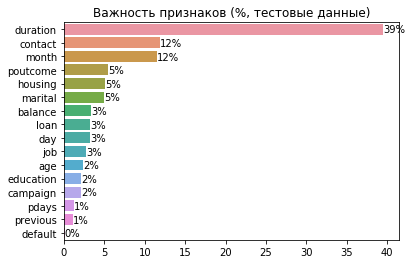

In [46]:
s = sv_ds.abs().median(0).sort_values(ascending=False)
s = s/s.sum()*100
sns.barplot(x=s.values, y=s.index)
for idx, t in enumerate(s.iteritems()):
    plt.text(t[1], idx+0.25, f"{t[1]:.0f}%")
plt.title('Важность признаков (%, тестовые данные)')
plt.show()

In [47]:
bin_funcs = {}

Первые 3 признака сильно лидируют по важности (duration, contact, month). Рассмотрим их более детально.

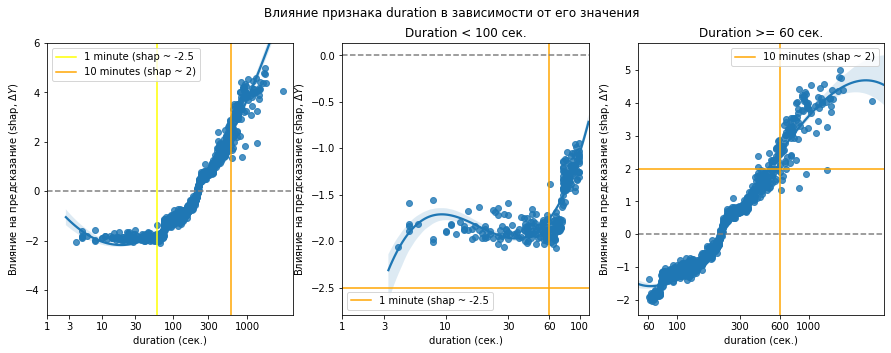

In [48]:
f = 'duration'
cds = pd.DataFrame()
cds[f] = np.log1p(X_test[f])
cds[f+'_shap'] = sv_ds[f].values

plt.figure(figsize=(15,5))
plt.subplot(131)
sns.regplot(x='duration', y=f+'_shap', data=cds, order=2)
xticks = np.array([1, 3,10,30,100,300,1000])
plt.axhline(0, linestyle='--', color='grey')
plt.axvline(np.log1p(60), color='yellow', label='1 minute (shap ~ -2.5')
plt.axvline(np.log1p(600), color='orange', label='10 minutes (shap ~ 2)')
plt.legend()
plt.xticks(np.log1p(xticks), xticks)
plt.ylim((-5,6))
plt.xlabel('duration (сек.)')
plt.ylabel(r'Влияние на предсказание (shap, $\Delta Y$)')

plt.subplot(132)
sns.regplot(x='duration', y=f+'_shap', data=cds[cds[f]<np.log1p(100)], order=3)
xticks = np.array([1, 3,10,30,60,100])
plt.axvline(np.log1p(60), color='orange', label='1 minute (shap ~ -2.5')
plt.axhline(-2.5, color='orange')
plt.legend()
plt.axhline(0, linestyle='--', color='grey')
plt.xlabel('duration (сек.)')
plt.ylabel(r'Влияние на предсказание (shap, $\Delta Y$)')
plt.title('Duration < 100 сек.')

plt.xticks(np.log1p(xticks), xticks)

plt.subplot(133)
sns.regplot(x='duration', y=f+'_shap', data=cds[cds[f]>=np.log1p(60)], order=3)
xticks = np.array([60, 100, 300, 600, 1000])
plt.xticks(np.log1p(xticks), xticks)
plt.axvline(np.log1p(600), color='orange', label='10 minutes (shap ~ 2)')
plt.axhline(2, color='orange')
plt.axhline(0, linestyle='--', color='grey')
plt.legend()
plt.xlabel('duration (сек.)')
plt.ylabel(r'Влияние на предсказание (shap, $\Delta Y$)')
plt.title('Duration >= 60 сек.')


plt.suptitle('Влияние признака duration в зависимости от его значения')
plt.show()

In [49]:
def binf_duration(x):
    b = pd.Series()
    b['<1m'] = x<60
    b['>=1m'] = x>=60
    b['>=1.5m'] = x>=100
    b['>=3m'] = x>=180
    b['>=5.5m'] = x>=325
    b['>=16.5m'] = x>=600
    return b.astype(int)

In [50]:
bin_funcs['duration'] = binf_duration

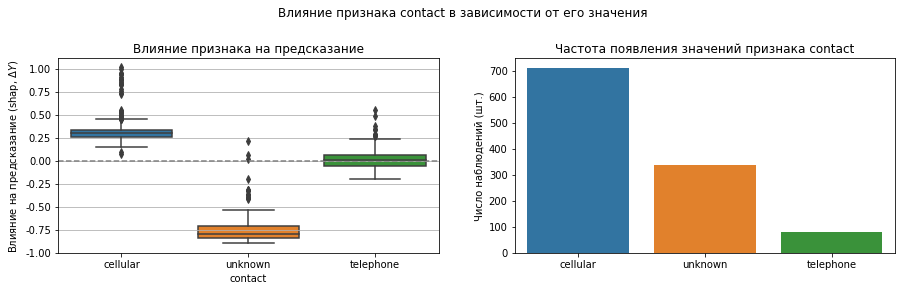

In [51]:
f = 'contact'
cds = pd.DataFrame()
cds[f] = X_test[f]
cds[f+'_shap'] = sv_ds[f].values

plt.figure(figsize=(15,4))
plt.subplot(121)
sns.boxplot(x=f, y=f+'_shap', data=cds)
plt.axhline(0, linestyle='--', color='grey')
plt.ylabel(r'Влияние на предсказание (shap, $\Delta Y$)')
plt.title('Влияние признака на предсказание')
yticks = np.arange(-1,1.1, 0.25)
plt.yticks(yticks, [f"{x:.2f}" for x in yticks])
plt.grid(axis='y')

plt.subplot(122)
s_ = cds[f].value_counts()
#s_ = s_/s_.sum()*100
sns.barplot(x=s_.index, y=s_.values)
plt.title(f'Частота появления значений признака {f}')
plt.ylabel('Число наблюдений (шт.)')

plt.subplots_adjust(top=0.8)
plt.suptitle('Влияние признака contact в зависимости от его значения')
plt.show()

In [52]:
def binf_contact(x):
    b = pd.Series()
    for v in ['cellular','unknown']:
        b[v] = x==v
    return b.astype(int)

In [53]:
bin_funcs['contact'] = binf_contact

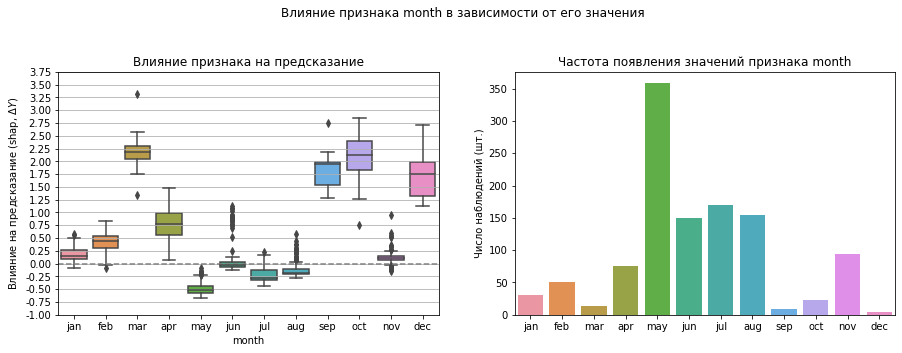

In [54]:
f = 'month'
cds = pd.DataFrame()
cds[f] = X_test[f]
cds[f+'_shap'] = sv_ds[f].values

plt.figure(figsize=(15,5))
plt.subplot(121)
sns.boxplot(x=f, y=f+'_shap', data=cds, order=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])
plt.axhline(0, linestyle='--', color='grey')
plt.ylabel(r'Влияние на предсказание (shap, $\Delta Y$)')
plt.title('Влияние признака на предсказание')
yticks = np.arange(-1,4,0.25)
plt.yticks(yticks, [f"{x:.2f}" for x in yticks])
plt.grid(axis='y')

plt.subplot(122)
s_ = cds[f].value_counts()
#s_ = s_/s_.sum()*100
s_ = s_.reindex(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])
sns.barplot(x=s_.index, y=s_.values)
plt.title(f'Частота появления значений признака {f}')
plt.ylabel('Число наблюдений (шт.)')

plt.subplots_adjust(top=0.8)
plt.suptitle(f'Влияние признака {f} в зависимости от его значения')
plt.show()

In [55]:
def binf_month(x):
    b = pd.Series()
    for v in ['feb', 'mar', 'apr', 'may', 'sep','oct','dec']:
        b[v] = x==v
    return b.astype(int)

In [56]:
bin_funcs['month'] = binf_month

Данные ужасны, но продолжим работу

In [57]:
implications = [('duration__>=1m','duration__>=1.5m'),
                   ('duration__>=1.5m','duration__>=3m'),
                   ('duration__>=3m','duration__>=5.5m'),
                   ('duration__>=5.5m', 'duration__>=16.5m')]

In [58]:
bin_ds = []
for f in tqdm_notebook(s[:3].index):
    cds = pd.concat([bin_funcs[f](x) for x in X_test[f]],1).T
    cds.columns = [f"{f}__{x}" for x in cds.columns]
    bin_ds.append(cds)
bin_ds = pd.concat(bin_ds,1)
bin_ds.index = X_test.index
print(bin_ds.shape)
bin_ds.head()


(1131, 15)


duration__<1m  duration__>=1m  duration__>=1.5m  duration__>=3m  \
2398              0               1                 1               0   
800               0               1                 1               1   
2288              0               1                 1               0   
2344              0               1                 1               1   
3615              0               1                 1               1   

      duration__>=5.5m  duration__>=16.5m  contact__cellular  \
2398                 0                  0                  1   
800                  1                  0                  1   
2288                 0                  0                  1   
2344                 0                  0                  0   
3615                 1                  0                  1   

      contact__unknown  month__feb  month__mar  month__apr  month__may  \
2398                 0           0           0           0           0   
800                  0           0           0           0           0   
2288                 0           0           0           0           0   
2344                 1           0           0           0           0   
3615                 0           1           0           0           0   

      month__sep  month__oct  month__dec  
2398           0           0           0  
800            0           0           0  
2288           0           0           0  
2344           0           0           0  
3615           0           0           0

In [59]:
import fca_interp as fcai

In [60]:
fcai = reload(fcai)

In [61]:
bin_ds = bin_ds.astype(bool)

In [62]:
%%time
cntx_bank = fcai.Context(bin_ds,y_true=y_test, y_pred=test_preds)
fm_bank = fcai.FormalManager(cntx_bank, ds_obj=None, task_type='binary classification')
fm_bank.construct_concepts(use_tqdm=False, is_monotonic=False)
fm_bank.construct_lattice(use_tqdm=False)

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.



CPU times: user 569 ms, sys: 0 ns, total: 569 ms
Wall time: 569 ms


In [63]:
#new_concepts = []
for c in fm_bank._concepts:
    intent = c._intent
    for f1, f2 in implications:
        if f1 in intent and f2 in intent:
            intent = [f for f in intent if f!=f1]
    c._intent = intent
#    new_concepts.append(c)
#fm_bank._concepts = new_concepts

/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [64]:
fig = fm_bank.get_plotly_fig(level_sort='all', sort_by='y_pred',
                        y_precision=2, title='Bank Dataset Concept Lattice', cbar_title='Mean Prediction',
                        color_by='y_pred',)

In [65]:
fig.show()

In [66]:
delete_all_lower_neighbs_downwise(fm_bank)

In [67]:
delete_nocontrib_concepts(fm_bank, conj_form=True, eps=0.05)

In [68]:
improv_metric = 'y_pred'
to_see = range(len(fm_bank._concepts)-1,0,-1)
for c_id in to_see:
    c = fm_bank.get_concept_by_id(c_id)
    if len(c.get_extent())==0:
        fm_bank.delete_concept(c_id)
        continue

    lns = c._low_neighbs
    c_val = dict({'y_true':c._y_true_mean, 'y_pred':c._y_pred_mean}, **c._metrics)[improv_metric]
    if len(lns)==0 and c_val not in [0,1]:
        fm_bank.delete_concept(c_id)
fm_bank.construct_lattice()

In [69]:
fig = fm_bank.get_plotly_fig(level_sort='all', sort_by='y_pred',
                        y_precision=2, title='Bank Dataset Concept Lattice', cbar_title='Mean Prediction',
                        color_by='y_pred',)

In [70]:
fig.show()

In [71]:
len(fm_bank._concepts)

19

In [72]:
plot_base_pos_neg_hypotheses(fm_bank)

-------------------------
-----Base hypothesis-----
-------------------------
0: _ -> 0.07

-------------------------
---Positive hypotheses---
-------------------------
2: duration__>=16.5m -> 0.40
3: duration__>=5.5m -> 0.20
4: month__mar -> 0.31
5: month__oct -> 0.48
6: duration__>=1.5m,month__dec -> 0.40
7: duration__>=1.5m,month__mar -> 0.57
8: duration__>=1.5m,month__oct -> 0.58
9: duration__>=16.5m,month__dec -> 1.00
11: duration__>=1m,month__sep -> 0.33
12: duration__>=3m,month__dec -> 0.50
13: duration__>=3m,month__oct -> 0.73
14: duration__>=5.5m,contact__cellular -> 0.26
15: duration__>=1.5m,contact__cellular,month__mar -> 0.67
16: duration__>=1m,contact__cellular,month__mar -> 0.40
17: duration__>=3m,contact__cellular,month__mar -> 1.00
18: duration__>=5.5m,contact__cellular,month__oct -> 0.80

-------------------------
---Negative hypotheses---
-------------------------
1: duration__<1m -> 0.00
10: duration__>=16.5m,month__feb -> 0.00


In [73]:
bin_ds_agg = get_context_by_concepts(fm_bank, bin_ds)
print(bin_ds_agg.shape)
bin_ds_agg.head()

(1131, 18)


month__oct  month__mar  duration__<1m  duration__>=5.5m  \
2398       False       False          False             False   
800        False       False          False              True   
2288       False       False          False             False   
2344       False       False          False             False   
3615       False       False          False              True   

      duration__>=16.5m  duration__>=1m&month__sep  \
2398              False                      False   
800               False                      False   
2288              False                      False   
2344              False                      False   
3615              False                      False   

      duration__>=1.5m&month__dec  duration__>=1.5m&month__oct  \
2398                        False                        False   
800                         False                        False   
2288                        False                        False   
2344                        False                        False   
3615                        False                        False   

      duration__>=1m&contact__cellular&month__mar  \
2398                                        False   
800                                         False   
2288                                        False   
2344                                        False   
3615                                        False   

      duration__>=1.5m&contact__cellular&month__mar  \
2398                                          False   
800                                           False   
2288                                          False   
2344                                          False   
3615                                          False   

      duration__>=1.5m&month__mar  duration__>=16.5m&month__feb  \
2398                        False                         False   
800                         False                         False   
2288                        False                         False   
2344                        False                         False   
3615                        False                         False   

      duration__>=3m&month__oct  duration__>=16.5m&month__dec  \
2398                      False                         False   
800                       False                         False   
2288                      False                         False   
2344                      False                         False   
3615                      False                         False   

      duration__>=3m&contact__cellular&month__mar  \
2398                                        False   
800                                         False   
2288                                        False   
2344                                        False   
3615                                        False   

      duration__>=5.5m&contact__cellular&month__oct  \
2398                                          False   
800                                           False   
2288                                          False   
2344                                          False   
3615                                          False   

      duration__>=5.5m&contact__cellular  duration__>=3m&month__dec  
2398                               False                      False  
800                                 True                      False  
2288                               False                      False  
2344                               False                      False  
3615                                True                      False

In [74]:
%%time
cntx_bank_mon = fcai.Context(~bin_ds_agg,y_true=y_test, y_pred=test_preds)
fm_bank_mon = fcai.FormalManager(cntx_bank_mon, ds_obj=None, task_type='binary classification')
fm_bank_mon.construct_concepts(use_tqdm=False, is_monotonic=True )
fm_bank_mon.construct_lattice(use_tqdm=False)

CPU times: user 4min 25s, sys: 0 ns, total: 4min 25s
Wall time: 4min 25s


In [75]:
fig = fm_bank_mon.get_plotly_fig(level_sort='all', sort_by='y_pred',
                        y_precision=2, title='Bank Dataset Concept Lattice', cbar_title='Mean Prediction',
                        color_by='y_pred',)

In [76]:
fig.show()

In [77]:
strong_neg_concepts = [c._idx for c in fm_bank_mon._concepts if c._y_pred_mean is not None and c._y_pred_mean<0.05]
len(strong_neg_concepts)

85

In [78]:
for c_idx in sorted(strong_neg_concepts):
    if all([ln_idx in strong_neg_concepts for ln_idx in fm_bank_mon.get_concept_by_id(c_idx)._low_neighbs]):
        strong_neg_concepts.remove(c_idx)

In [79]:
strong_neg_concepts

[1948,
 1577,
 1572,
 1294,
 1201,
 1194,
 1196,
 965,
 911,
 913,
 901,
 845,
 843,
 842,
 679,
 628,
 636,
 630,
 589,
 544,
 583,
 581,
 568,
 381,
 409,
 391,
 343,
 407,
 371,
 374,
 342,
 372,
 376,
 327,
 325,
 333,
 339,
 216,
 211,
 200,
 166,
 196,
 197,
 198,
 202,
 186,
 184,
 168,
 174,
 170,
 175,
 176,
 204,
 165,
 83,
 74,
 73,
 72,
 35,
 33,
 10,
 32,
 31,
 78,
 30,
 29,
 27,
 11,
 26,
 96,
 95,
 94,
 9,
 92,
 89,
 80,
 3,
 84,
 82]

In [80]:
strong_neg_concepts = [c for c in strong_neg_concepts if not any([c_.is_subconcept_of(c) for c_ in strong_neg_concepts if c_!=c])]
len(strong_neg_concepts)

AttributeError: 'int' object has no attribute 'is_subconcept_of'

In [ ]:
strong_neg_concepts

In [ ]:
for c in strong_neg_concepts:
    print('* '+'\n* OR '.join(c._intent))
    print('---------')

* duration__<1m
* OR month__mar
* OR duration__>=1.5m&month__dec
* OR duration__>=16.5m&month__feb

In [ ]:
test_preds[X_test['duration']<60].mean()

In [ ]:
test_preds[bin_ds['month__mar']].mean()

In [ ]:
test_preds[X_test['month']=='mar'].mean()

In [ ]:
plot_concepts_as_hypotheses(strong_neg_concepts)

In [ ]:
strong_neg_concepts[0].is_subconcept_of(strong_neg_concepts[2])

In [ ]:
strong_neg_concepts[0].is_subconcept_of

In [ ]:
strong_neg_concepts = 

In [ ]:
delete_nocontrib_concepts(fm_bank_mon, eps=0.05)

In [ ]:
fig = fm_bank_mon.get_plotly_fig(level_sort=2, sort_by='y_pred',
                        y_precision=2, title='Bank Dataset Concept Lattice', cbar_title='Mean Prediction',
                        color_by='y_pred',)

In [ ]:
fig.show()

In [ ]:
border_hyps = [c for c in fm_bank_mon._concepts if c._y_pred_mean in [0,1]]
border_hyps = sorted(border_hyps, key=lambda c: '|'.join(c._intent))

In [ ]:
for bh in tqdm_notebook(border_hyps):
    to_del_hyps = [c for c in fm_bank_mon._concepts if all([m in c._intent for m in bh._intent]) and c!=bh]
    fm_bank_mon._concepts = [c for c in fm_bank_mon._concepts if c not in to_del_hyps]

In [ ]:
idx_map = {c_._idx: i for i, c_ in
           enumerate(sorted(fm_bank_mon._concepts, key=lambda c_: (len(c_.get_intent()), ','.join(c_.get_intent()))))
          }

In [ ]:
for c in fm_bank_mon._concepts:
    c._idx = idx_map[c._idx]

In [ ]:
fm_bank_mon._top_concept = fm_bank_mon.get_concept_by_id(0)

In [ ]:
fm_bank_mon.construct_lattice(use_tqdm=False)

In [ ]:
fig = fm_bank_mon.get_plotly_fig(level_sort=2, sort_by='y_pred',
                        y_precision=2, title='Bank Dataset Concept Lattice', cbar_title='Mean Prediction',
                        color_by='y_pred',)

In [ ]:
fig.show()

In [ ]:
plot_base_pos_neg_hypotheses(fm_bank_mon, base_pred=test_preds.mean())

-----Base hypothesis-----
-------------------------
0. : _ -> 0.08


---Positive hypotheses---
-------------------------
2. : duration__>=16.5m & month__dec -> 1.00
3. : duration__>=1m & month__sep -> 0.33
4. : duration__>=3m & contact__cellular & month__mar -> 1.00
5. : duration__>=5.5m & contact__cellular & month__may -> 0.17
6. : duration__>=5.5m & contact__cellular & month__oct -> 1.00
7. : duration__>=1m & month__sep OR duration__>=5.5m & contact__cellular & month__may -> 0.20


---Negative hypotheses---
-------------------------
1. : duration__<1m -> 0.00
8. : month__may -> 0.02
9. : month__may OR (duration__>=1m & month__sep) -> 0.03